In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/var/folders/hv/b1wcvr5j7bb1mzjm00fwl5zm0000gn/T/ipykernel_6120/2694951121.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# fetch the KDD99Cup dataset
file_path = '/Users/nisha/Desktop/spring2024/MachineLearning/kddcup99_csv.csv'
df = pd.read_csv(file_path)

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [3]:
# identify names of dos attacks
# https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']

# one hot encode "label" column -> 1 for dos attacks, 0 for non dos attacks
df['label'] = df['label'].apply(lambda x: 1 if x in dos_attacks else 0)

In [4]:
# one hot encode all other categorical features into numerical features
    # must happen or it causes errors when the model tries to convert string values to float
categorical_columns = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical_columns])
# convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
# concatenate the encoded_df with the original df & drop the original columns
df_encoded = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)

df_encoded.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,239,486,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,235,1337,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,219,1337,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,217,2032,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# split data into test and train
X = df_encoded.iloc[:, :-1]
y = df_encoded.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# undersample majority class to make the dataset balanced
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [7]:
print(X_train.shape)
print(X_train_resampled.shape)

print(y_train.shape)
print(y_train_resampled.shape)

(395216, 118)
(178, 118)
(395216,)
(178,)


### Note the use of RandomUnderSampler has drastically decreased the size of our data.

In [8]:
# scale data
scaler = StandardScaler()
scaler.fit(X_train_resampled)
X_train_scaled = scaler.transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [9]:
# train SVM model with 4 diff kernels
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = []
accuracies.append(['Kernel Type', 'Train Accuracy', 'Test Accuracy'])
weights = []
for i in kernel:
    svm=SVC(gamma='auto', kernel=i)
    svm.fit(X_train_scaled, y_train_resampled)
    # accuracies array
    y_train_pred = svm.predict(X_train_scaled)
    y_test_pred = svm.predict(X_test_scaled)
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append([i, train_accuracy, test_accuracy])
    # get weights of features to determine which features are important for this problem
        # can only do this with a linear kernel for svm.SVC
    if i == 'linear':
        # weights array
        features_df = df_encoded.drop('label', axis=1)
        feature_names = features_df.columns.tolist()
        coef_abs = np.abs(svm.coef_[0])
        feature_importance = pd.DataFrame(coef_abs, index=feature_names, columns=['abs_weight'])
        feature_importance_sorted = feature_importance.sort_values(by='abs_weight', ascending=False)
        weights.append(feature_importance_sorted)

In [10]:
accuracies_df = pd.DataFrame(accuracies)
print(accuracies_df)

             0               1              2
0  Kernel Type  Train Accuracy  Test Accuracy
1       linear             1.0       0.988098
2         poly        0.578652         0.1689
3          rbf             1.0       0.997571
4      sigmoid             1.0       0.999119


In [11]:
# poly performed so poorly so I am trying to see if it performs better with different degrees
degree = [3, 10, 30, 50]
accuracies2 = []
accuracies2.append(['Degree', 'Train Accuracy', 'Test Accuracy'])
for i in degree:
    svm=SVC(gamma='auto', kernel='poly', degree=i)
    svm.fit(X_train_scaled, y_train_resampled)
    # accuracies array
    y_train_pred = svm.predict(X_train_scaled)
    y_test_pred = svm.predict(X_test_scaled)
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracies2.append([i, train_accuracy, test_accuracy])

In [12]:
accuracies_df2 = pd.DataFrame(accuracies2)
print(accuracies_df2)

        0               1              2
0  Degree  Train Accuracy  Test Accuracy
1       3        0.578652         0.1689
2      10        0.561798       0.099176
3      30        0.561798        0.09283
4      50        0.561798       0.091292


### Linear Kernel:
    Pros:
        Both the training and testing accuracies are high.
        The kernel is very simple- therefore, it's an efficient choice.
    Cons:
        May not perform as well on data that isn't linearly seperable.
### Polynomial Kernel:
    Pros:
        Can model non-linear decision boundaries well.
    Cons:
        Poor training accuracy and even worse testing accuracy (even after trying several different degrees)- suggesting overfitting.
        If the kernel has a high-degree polynomial, it can be computationally intensive.
### RBF Kernel:
    Pros:
         Both the training and testing accuracies are high.
         Can capture non-linear relationships in data.
    Cons:
        Computationally expensive.
        It's accuracy can be changed heavily by the choice of gamma (the wrong gamma can cause overfitting).
### Sigmoid Kernel:
    Pros:
        Both the training and testing accuracies are high.
        Can model non-linear and sigmoidal relationships in data.
    Cons:
        It's accuracy can be changed heavily by the choice of C and alpha

In [13]:
# find which features are most important
print(weights[0])

                             abs_weight
flag_S1                        0.179933
protocol_type_icmp             0.131909
dst_host_same_src_port_rate    0.129754
dst_host_diff_srv_rate         0.126101
same_srv_rate                  0.125878
...                                 ...
lnum_root                      0.000000
service_http                   0.000000
service_hostnames              0.000000
lnum_file_creations            0.000000
service_ftp                    0.000000

[118 rows x 1 columns]


### Features 'flag_S1' and 'protocol_type_icmp' are the features with the highest weight for the linear SVM. Therefore, I am going to guess that they are two features which are very important for this problem. Now, I will train SVM using just these two features.

In [14]:
# create X and y following the same methods as before
X = df_encoded[['flag_S1', 'protocol_type_icmp']]
y = df_encoded.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
scaler = StandardScaler()
scaler.fit(X_train_resampled)
X_train_scaled = scaler.transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [15]:
# train SVM with linear and RBF kernel on two features
lin_svm = SVC(gamma='auto', kernel='linear').fit(X_train_scaled, y_train_resampled)
rbf_svm = SVC(gamma='auto', kernel='rbf').fit(X_train_scaled, y_train_resampled)

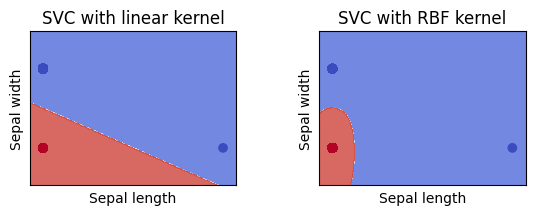

In [16]:
# from https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel']


for i, clf in enumerate((lin_svm, rbf_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_resampled, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

### The linear kernel creates a linear decision boundary between the two features. This decision boundary is simpler and also leads to a better balance between the red and blue space. The RBF kernel creates a non-linear decision boundary between the two features. This decision boundary is tighter than the linear boundary.